In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable tensorflow GPU
import sys
sys.path.insert(0, "src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dataset.CubiCasaDatset import CubiCasaDatset
from deeplearning.semantic_segmentation.UNet.UNet import UNetModelBuilder
from processing.ocr import TesseractOCR
import os

from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

from PIL import Image
from six import BytesIO

import shapely
# from shapely.geometry import LineString, Polygon, MultiPolygon, GeometryCollection
# from shapely.ops import unary_union, split

import cv2

from processing.image_to_walls import ImageToWalls

from processing.utils.point_to_line_dist import point_to_line_dist
from processing.utils.line_angle import calculate_angle

In [3]:
%matplotlib inline

In [4]:
image_size = 512
ds = CubiCasaDatset(image_channels=3,image_size=image_size)

# sample = ds.get_sample(800)  # 1237 is a simple one , 800 with difficult wall 
# to_predict_image = np.array(sample['image'].numpy(),dtype=int)
# fig, (ax1) = plt.subplots(1,1,figsize=(8,8))
# ax1.imshow(to_predict_image)

In [5]:
! ls input/dutch_samples

dgw.png  hogepad.png  laan_oud_indiegangers.png  oranjestraat.png


(512, 512, 3)


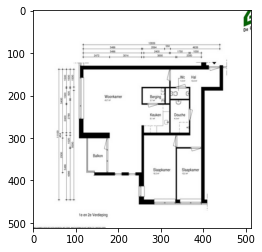

In [6]:
to_predict_image = Image.open('input/dutch_samples/dgw.png')
to_predict_image = to_predict_image.convert('RGB')
to_predict_image = to_predict_image.resize((image_size, image_size))
to_predict_image = np.array(to_predict_image, dtype=int)
print(to_predict_image.shape)
plt.imshow(to_predict_image)

In [5]:
mb = UNetModelBuilder(False)
model = mb.build_model()
model.compile(loss="binary_crossentropy")
model.load_weights('weights/unet/model.h5')

<ipython-input-70-7c8530d8d45f>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


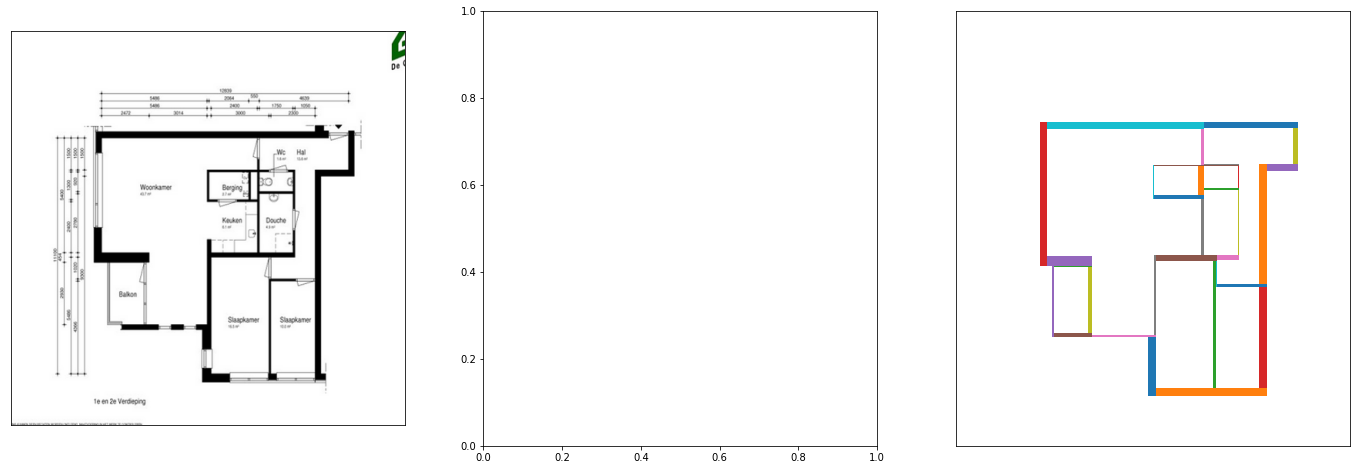

In [70]:
#for i in [6,33,69,77,100,300,600,800,1200,3000,3100, 4000, 4500]:
# for i in [1200]:

fig, (ax2,ax3,ax4) = plt.subplots(1,3,figsize=(8*3,8))

#     sample = ds.get_sample(i) 
#     to_predict_image = np.array(sample['image'].numpy(),dtype=int)
#     y_pred = model.predict(np.expand_dims(to_predict_image[:,:,0], axis=0))[0] > 0.5

to_predict_image = Image.open('input/dutch_samples/dgw.png')
to_predict_image = to_predict_image.convert('RGB')
to_predict_image = to_predict_image.resize((image_size, image_size))
to_predict_image = np.array(to_predict_image, dtype=int)



y_pred = model.predict(np.expand_dims(to_predict_image[:,:,0], axis=0))[0] > 0.5

image_to_walls = ImageToWalls()

morph_result = image_to_walls.morphology_steps(y_pred)

linestrings = image_to_walls.get_contours_as_linestring(morph_result)
linestrings = image_to_walls.fix_lines_angles(linestrings.copy(),25)

wall_polys = image_to_walls.get_base_poly(linestrings)

walls = image_to_walls.all_walls_poly_to_walls(wall_polys)

# display(wall_polys)

ax2.imshow(to_predict_image,cmap="gray")

# Show walls
for wall in walls: 
    ax4.fill(wall.exterior.xy[0],wall.exterior.xy[1], )


# # Show lines
# for linestring_i, linestring in enumerate(linestrings):
#     ax2.plot(list(linestring[:,0]) + [linestring[0,0]] , list(linestring[:,1]) + [linestring[0,1]])
#     ax2.scatter(linestring[:,0], linestring[:,1], c="red")


ax2.set_ylim(512,0)
ax2.set_xlim(0,512)

ax4.set_ylim(512,0)
ax4.set_xlim(0,512)


ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)




# plt.title(str(i))
fig.show()


In [44]:
import cv2

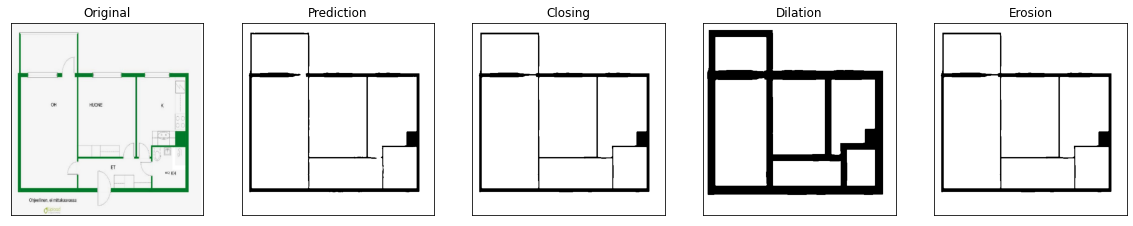

In [66]:
sample = ds.get_sample(500) 
to_predict_image = np.array(sample['image'].numpy(),dtype=int)
y_pred = model.predict(np.expand_dims(to_predict_image[:,:,0], axis=0))[0] > 0.5


fig, (ax1,ax2,ax3,ax4, ax5) = plt.subplots(1,5,figsize=((8*5)/2,8/2))
image = y_pred.copy()
kernel = np.ones((15,15),np.uint8)
closing = cv2.morphologyEx(np.float32(image), cv2.MORPH_CLOSE, kernel)

dilation = cv2.dilate(closing,kernel,iterations = 1)

erosion = cv2.erode(dilation,kernel,iterations = 1)

gray = cv2.cvtColor(np.flip(np.repeat(erosion.reshape(512,512,1),3, axis=2),axis=0), cv2.COLOR_BGR2GRAY).astype('uint8')

gray = np.flip(gray, axis=0)


ax1.imshow(to_predict_image)
ax1.title.set_text("Original")
ax2.imshow(y_pred, cmap="Greys")
ax2.title.set_text("Prediction")
ax3.imshow(closing, cmap="Greys")
ax3.title.set_text("Closing")
ax4.imshow(dilation, cmap="Greys")
ax4.title.set_text("Dilation")
ax5.imshow(erosion, cmap="Greys")
ax5.title.set_text("Erosion")




ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)


ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)

ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)

ax5.axes.get_xaxis().set_visible(False)
ax5.axes.get_yaxis().set_visible(False)
